### CSE 5320 Neural Networks Project 3 with Paper
#### Report (with Code)
Josias Moukpe\
12/10/2022

#### Introduction
Text Generation is a branch of Natural Language Processing (NLP) that predicts the
next most likely word given all the previous words. State of the art in Text Generation
has recently been the domain of Language Models based on Transformers pretrained
on large corpora of text data from various sources on the internet. These pretrained
generative transformers are often fine-tuned on a downstream dataset for a
downstream task of interest. This project aims to develop a generative language model
based on a pretrained language transformer fine-tuned on our two chosen datasets:
Merve-Poetry [1] and Rap Lyrics US [2]. We want to obtain a fine-tuned model that can
generate original English poetry given an initial prompt and another that can generate
original rap lyrics inspired by the styles of contemporary rappers. Both datasets contain
English text from various authors and will be processed to extract the bags of words.
Those words will then be converted to a designated embedding before being ingested
by the generative model during fine-tuning. The pretrained model will be obtained from
the Hugging Face library of generative models for English text.
Merve Poetry contains renaissance and modern poetries from subjects such as Love,
Nature, Mythology, and Folklore. The dataset is organized into 5 table columns: the
poem's content, author, age, and subject type. Rap Lyrics US contains text documents
organized by artists. Each text document includes lyrics from the corresponding artist.
The final models will take an initial sequence of words (prompt) and generate a
sequence from an original poem and rap song.

#### Problem


#### Methodology


#### Benchmarking


#### Conclusion



References\
[1] https://huggingface.co/datasets/merve/poetry/viewer/merve--poetry/train\
[2] https://github.com/fpaupier/RapLyrics-Scraper/tree/master/lyrics_US\
[3]https://huggingface.co/models?language=en&library=tf&pipeline_tag=text-generation&sort=downloads\
[3] https://www.projectpro.io/recipes/what-is-causal-language-modeling-transformers\
[4] https://towardsdatascience.com/understanding-masked-language-models-mlm-and-causal-language-models-clm-in-nlp-194c15f56a5

#### Remote Training Environment Setup

In [ ]:
%pip install tensorflow_addons

In [18]:
# imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow_addons.optimizers import AdamW
from tqdm import tqdm
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.strings import regex_replace
from transformers import AutoTokenizer
from transformers import TFOPTForCausalLM
from transformers import OPTConfig
from transformers import DataCollatorForLanguageModeling

In [3]:
# gpu
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Handling the data

In [4]:
poems_path = './data/poems.json'
lyrics_path = './data/lyrics.json'

In [5]:
# use a generator to read the json file
def parse(dataset_path):
    '''
        This function reads the json file and returns a generator
    '''
    dataf = open(dataset_path, 'r', encoding='utf-8')
    for line in dataf:
        # get the text and stars
        yield json.loads(line)['author'], json.loads(line)['content']


In [6]:
def plot_stats(dataset_path):
    '''
        This function plots the number of authors and content,
        the average number of words per content and the average
        number of characters per content
    '''
    authors = []
    contents = []
    for author, content in parse(dataset_path):
        authors.append(author)
        contents.append(content)
        
    # number of authors
    print('Number of authors: ', len(set(authors)))

    # number of contents
    print('Number of contents: ', len(contents))

    # average number of words per content
    print('Average number of words per content: ', np.mean([len(content.split()) for content in contents]))

    # longest number of words per content
    print('Longest number of words per content: ', np.max([len(content.split()) for content in contents]))

    # shortest number of words per content
    print('Shortest number of words per content: ', np.min([len(content.split()) for content in contents]))

    # for every content, count the number of characters
    print('Average number of characters per content: ', np.mean([len(content) for content in contents]))

    # for every author, count the number of contents
    authors_count = {}
    for author in authors:
        if author in authors_count:
            authors_count[author] += 1
        else:
            authors_count[author] = 1

    # plot the number of contents per author
    plt.figure(figsize=(20, 10))
    plt.bar(authors_count.keys(), authors_count.values())
    plt.xticks(rotation=90)
    plt.title('Number of contents per author')
    plt.xlabel('Author')
    plt.ylabel('Number of contents')
    plt.show()

    # for every content, count the number of words
    contents_count = {}
    for content in contents:
        if len(content.split()) in contents_count:
            contents_count[len(content.split())] += 1
        else:
            contents_count[len(content.split())] = 1

    # plot the number of contents per number of words
    plt.figure(figsize=(20, 10))
    plt.bar(contents_count.keys(), contents_count.values())
    plt.xticks(rotation=90)
    plt.title('Number of contents per number of words')
    plt.xlabel('Number of words')
    plt.ylabel('Number of contents')
    plt.show()
    

    

Number of authors:  67
Number of contents:  1818
Average number of words per content:  53.476897689768975
Longest number of words per content:  677
Shortest number of words per content:  1
Average number of characters per content:  277.65346534653463


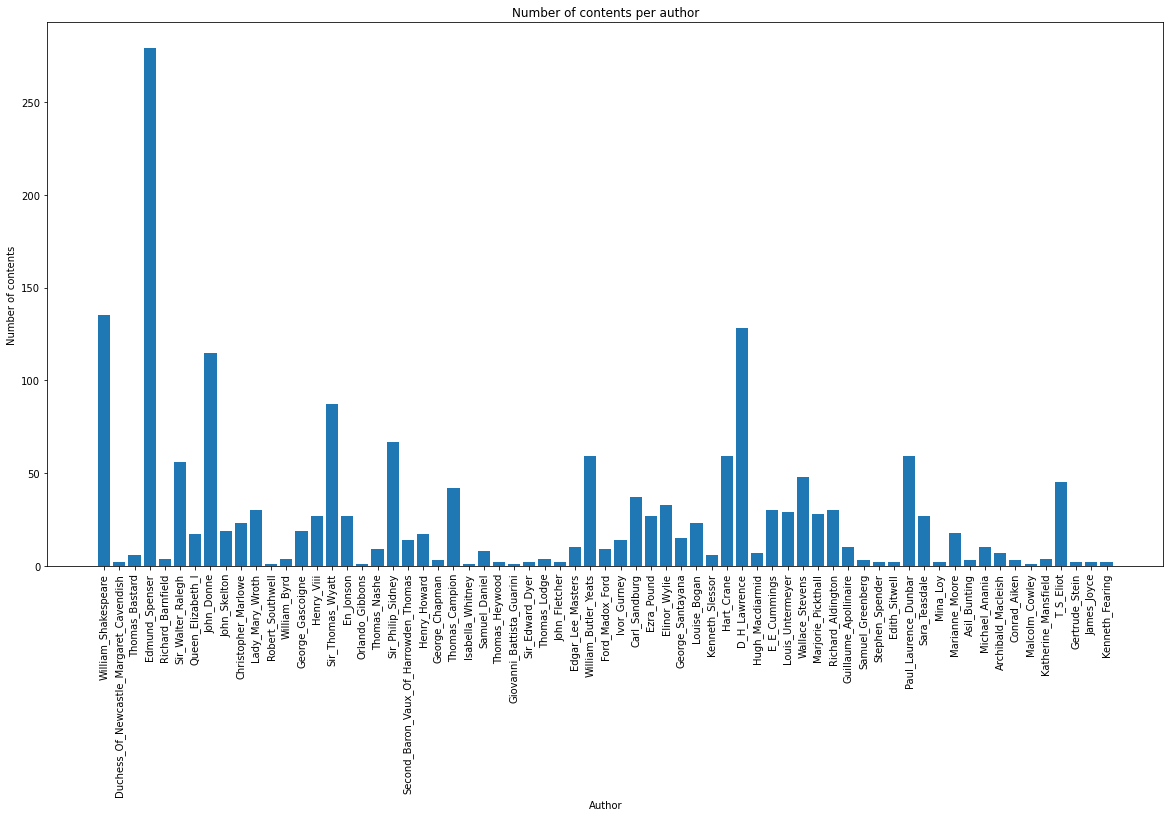

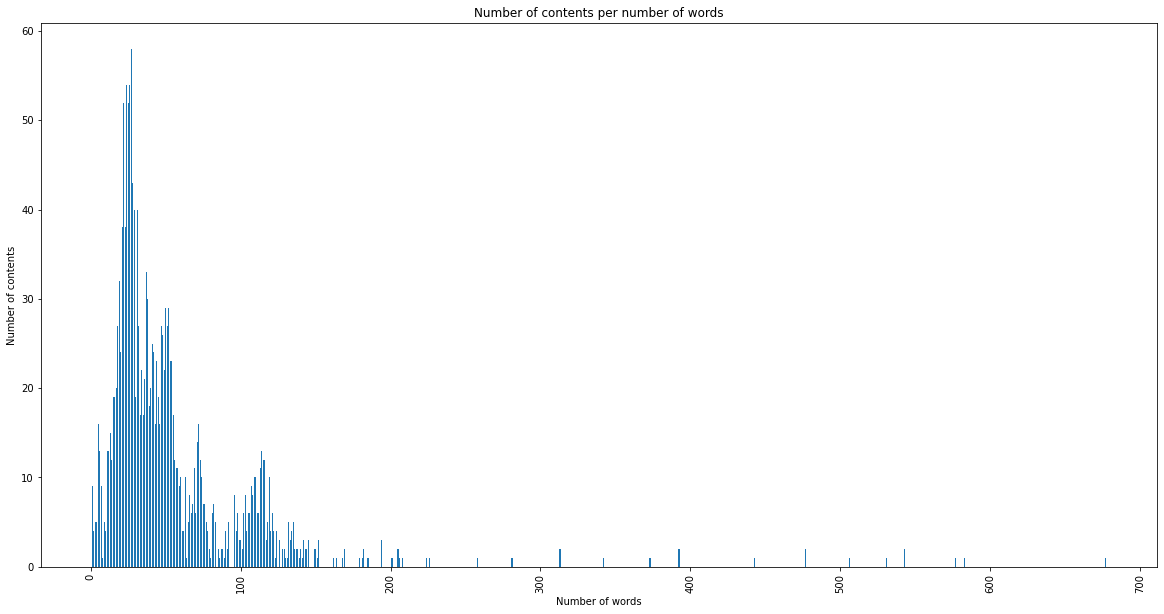

In [19]:

# plot the stats for the poems dataset
plot_stats(poems_path)


Number of authors:  36
Number of contents:  10255
Average number of words per content:  121.0258410531448
Longest number of words per content:  2943
Shortest number of words per content:  1
Average number of characters per content:  619.8157971721112


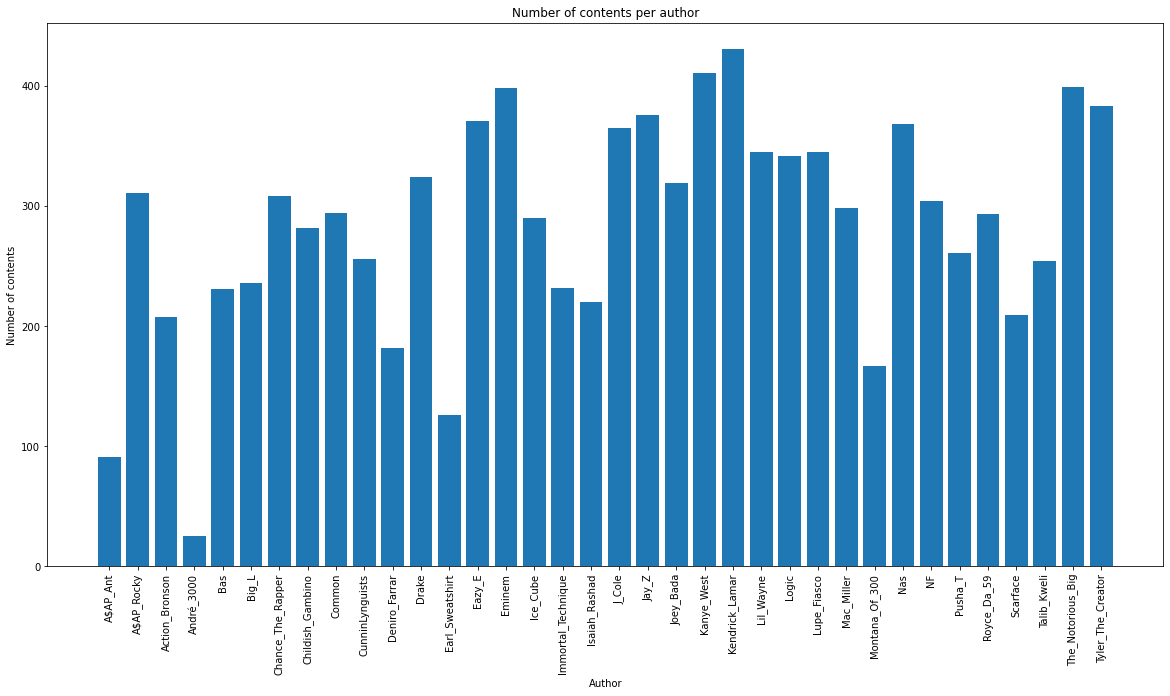

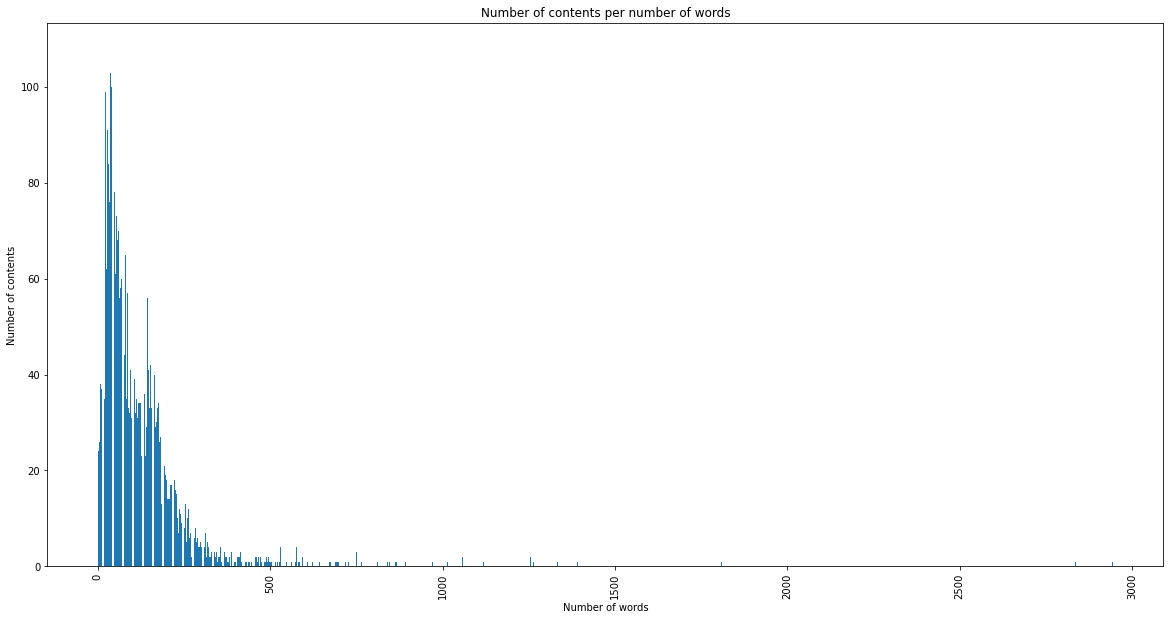

In [20]:
plot_stats(lyrics_path)

In [44]:
# read path file write to a json file
def split_dataset(name, og_path, split=[.8, .1, .1]):
    '''
        read a json file and split it into train, test, and validation
        files according to the split parameter
    '''
    # get directory path
    dir_path = '/'.join(og_path.split('/')[:-1])
    # get the generator
    data = parse(og_path)
    # loop through the generator
    for author, content in data:
        # generate a random number between 0 and 1
        r = np.random.rand()
        # if the random number is less than the first split
        if r < split[0]:
            # write to the train file
            with open(dir_path + f'/{name}_train.json', 'a') as f:
                f.write(json.dumps({'author': author, 'content': content}))
                f.write('\n')
        # if the random number is less than the first split plus the second split
        elif r < split[0] + split[1]:
            # write to the validation file
            with open(dir_path + f'/{name}_val.json', 'a') as f:
                f.write(json.dumps({'author': author, 'content': content}))
                f.write('\n')
        # if the random number is less than the first split plus the second split plus the third split
        else:
             # write to the test file
            with open(dir_path + f'/{name}_test.json', 'a') as f:
                f.write(json.dumps({'author': author, 'content': content}))
                f.write('\n')

In [ ]:
# split the poems dataset
split_dataset('poems', poems_path)

#### Handling the Model

In [19]:
MODEL = 'facebook/opt-125m'
MODELX = 'facebook/opt-350m'
# consts
OPT_DROPOUT = 0.1
OPT_ATT_DROPOUT = 0.1
LAYER_DROPOUT = 0.1

MAX_LEN = 2048
CONTEXT_LEN = 1024 #TODO: investigate lower values
BATCH_SIZE = 8 # 48 on gradient  
INIT_LR = 9e-6
MAX_LR = 1e-4
BETA1 = 0.9
BETA2 = 0.95
WEIGHT_DECAY = 0.1
W_INIT_MEAN = 0.0
W_INIT_STDDEV = 0.006
B_INIT_VALUE = 0.0

RANDOM_SEED = 42
NUM_EPOCHS = 5


DATA_CARDINALITY = 10255
N_TRAIN_SAMPLES = 10255
# N_TEST_SAMPLES = #TODO: how to test model for clm?
# N_VAL_SAMPLES = 

factor = .15 # 15%
STEP_PER_EPOCH = int((N_TRAIN_SAMPLES // BATCH_SIZE) * factor)
# STEP_PER_VALIDATION = int((N_VAL_SAMPLES // BATCH_SIZE) * factor)
# STEP_PER_TEST = int((N_TEST_SAMPLES // BATCH_SIZE) * factor)

In [8]:
# define cyclic learning rate
clr = CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.** (x - 1)),
    step_size=2 * STEP_PER_EPOCH,
    scale_mode='cycle'
)

In [12]:
# define optimizer
optimizer = AdamW(
    learning_rate=clr,
    beta_1=BETA1,
    beta_2=BETA2,
    weight_decay=WEIGHT_DECAY,
)

In [17]:
initializer = TruncatedNormal(
    mean=W_INIT_MEAN,
    stddev=W_INIT_STDDEV,
    seed=RANDOM_SEED
)

In [13]:
# preprocess the data
def preprocess(text):
    '''
        This function preprocesses the text
    '''
    # convert to lowercase
    text = text.lower()
    # remove non-alphanumeric characters, TODO: investigate if it is better to keep them
    text = regex_replace(text, r'[^a-zA-Z0-9\s]', '') 
    # remove extra spaces
    text = regex_replace(text, r'\s+', ' ')
    # convert to string
    text = str(text)
    # return the preprocessed text
    return text

In [21]:
# configure the model
model_name = MODEL
# tokenizer
Tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)


In [32]:
# run the tokenizer on the text
def tokenize(text, tokenizer=Tokenizer):
    '''
        This function tokenizes the text
    '''
    # tokenize the text
    tokenized_text = tokenizer(
        text, 
        truncation=True,
        max_length=CONTEXT_LEN,
        return_overflowing_tokens=True,
        return_length=True,
        # padding='max_length',
        return_tensors='tf'
    )
    # return the tokenized text
    return tokenized_text


In [33]:
def detokenize(tokenized_text, tokenizer=Tokenizer):
    '''
        This function detokenizes the text
    '''
    # detokenize the text
    detokenized_text = tokenizer.decode(tokenized_text)
    # return the detokenized text
    return detokenized_text

In [34]:
# test
text = 'This is a test'
tokenized_text = tokenize(text)
# print(tokenized_text)
print(tokenized_text['input_ids'])
print(tokenized_text['attention_mask'])
# detokenized_text = detokenize(tokenized_text)
# print(detokenized_text)

tf.Tensor([[   2  713   16   10 1296]], shape=(1, 5), dtype=int32)
tf.Tensor([[1 1 1 1 1]], shape=(1, 5), dtype=int32)


In [42]:

# configure gpu for sequence classification
config = OPTConfig(
    dropout=OPT_DROPOUT, # still works here
    attention_dropout=OPT_ATT_DROPOUT, # still works here
    output_hidden_states=True,
    n_ctx=CONTEXT_LEN,
    bos_token_id=Tokenizer.bos_token_id,
    eos_token_id=Tokenizer.eos_token_id,
)
# load the model, TODO: investigate which model to use
pretrained_model = TFOPTForCausalLM.from_pretrained(model_name, config=config)
# freeze the model
for layer in pretrained_model.layers:
    layer.trainable = False



All model checkpoint layers were used when initializing TFOPTForCausalLM.

All the layers of TFOPTForCausalLM were initialized from the model checkpoint at facebook/opt-125m.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOPTForCausalLM for predictions without further training.


In [43]:
# test pretrained model
test_text = 'This is a test'
test_tokenized_text = tokenize(test_text)
# print(test_tokenized_text)
test_output = pretrained_model(test_tokenized_text['input_ids'], test_tokenized_text['attention_mask'])
print(test_output)
test_logits = test_output.logits
print(test_logits)


IndexError: list index out of range

In [ ]:
def build_opt(transformer, max_len=MAX_LEN):
    '''
        This function builds the model
        input:
            - transformer: the transformer
            - max_len: the maximum length
        output:
            - model: the model
    '''
    
    # get the input
    input_ids = Input(
        shape=(max_len,), 
        dtype=tf.int32, 
        name='input_ids',
        # batch_size=BATCH_SIZE
        )

    # get the attention mask
    attention_mask = Input(
        shape=(max_len,),
        dtype=tf.int32,
        name='attention_mask',
        # batch_size=BATCH_SIZE
        )


    # get the transformer output
    last_hidden_state = transformer(input_ids,attention_mask=attention_mask)[0]
    cls_token = last_hidden_state[:, 0, :]
    # add dropout
    cls_token = Dropout(rate=LAYER_DROPOUT,seed=RANDOM_SEED,)(cls_token)
    # get the output
    output = Dense(
        NUM_CLASSES,
        activation='softmax',
        kernel_initializer=initializer,
        kernel_constraint=None,
        bias_initializer='zeros',
        name='output',
        # batch_size=BATCH_SIZE
        )(cls_token)

    # build the model
    model = Model(
        inputs=[input_ids, attention_mask],
        outputs=output
    )

    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=clr),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # return the model
    return model



#### Evaluating the model (on and off metrics)


#### Remarks
Don't train on both dataset at the same time, might not find commonality
Trained on causal language modeling
768 attention vector dimension for opt-125
1024 attention vector dim for opt-350
in Causal Language Modeling, inputs are labels so it's self-supervised
During this project...